In [37]:
# import packages 导入库，搭建环境
import numpy as np
import pandas as pd  
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# ignore warnings 可以删除
import warnings
warnings.filterwarnings('ignore')

# 为了让matplotlib里显示中文字符
import matplotlib.font_manager as fm 
matplotlib.rcParams['font.family'] = 'Microsoft Yahei' # 设置字体

In [38]:
# 导入机器学习库
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV

# 投票分类器
# mlxtend库的分类器可以利用训练完成的分类器直接根据投票权重输出结果 
# sklearn的分类器则需要重新训练
from mlxtend.classifier import EnsembleVoteClassifier
# from sklearn.ensemble import VotingClassifier

In [39]:
# 英特尔加速扩展，需去除
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [40]:
# data import 数据导入
df = pd.read_csv('保单数据.csv', )

In [41]:
# data overview 数据概览
# 目标变量
target = '是否骗保'
# 连续型变量
continous_feature = df.columns[df.dtypes == 'int64'].tolist()
# 删除目标变量和ID
continous_feature.remove(target)
continous_feature.remove('保单编号')
# 离散型变量
categorical_feature = df.columns[df.dtypes != 'int64'].tolist()

print('连续型变量：', continous_feature)
print('离散型变量：', categorical_feature)

连续型变量： ['事故月中周数', '出险月中周数', '出险人年龄', '客服编号', '起付额', '驾驶员评级', '事故年份']
离散型变量： ['事故月份', '事故周中天数', '品牌', '事故发生区域', '出险周中天数', '出险月份', '出险人性别', '出险人婚姻状况', '责任划分', '保单类别', '车辆类别', '车辆价格', '事故距离保单生效天数', '出险距离保单生效天数', '历史出险次数', '车龄', '投保人年龄', '是否出警', '是否有目击者', '中介类型', '补充出险次数', '出险距离地址变动时间', '投保人车辆数', '车险类别']


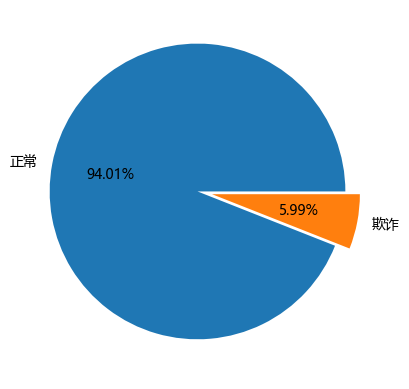

In [42]:
# visualize the distribution of target variable 可视化目标变量分布
# 计算对应客户数量
ontime = df[df[target] == 0].shape[0]
default = df[df[target] == 1].shape[0]
# 总客户数
total = [ontime, default]
# 标签
label = ['正常', '欺诈']
# 绘制饼图
plt.pie(total, labels = label, autopct = '%1.2f%%', explode = (0.1, 0));

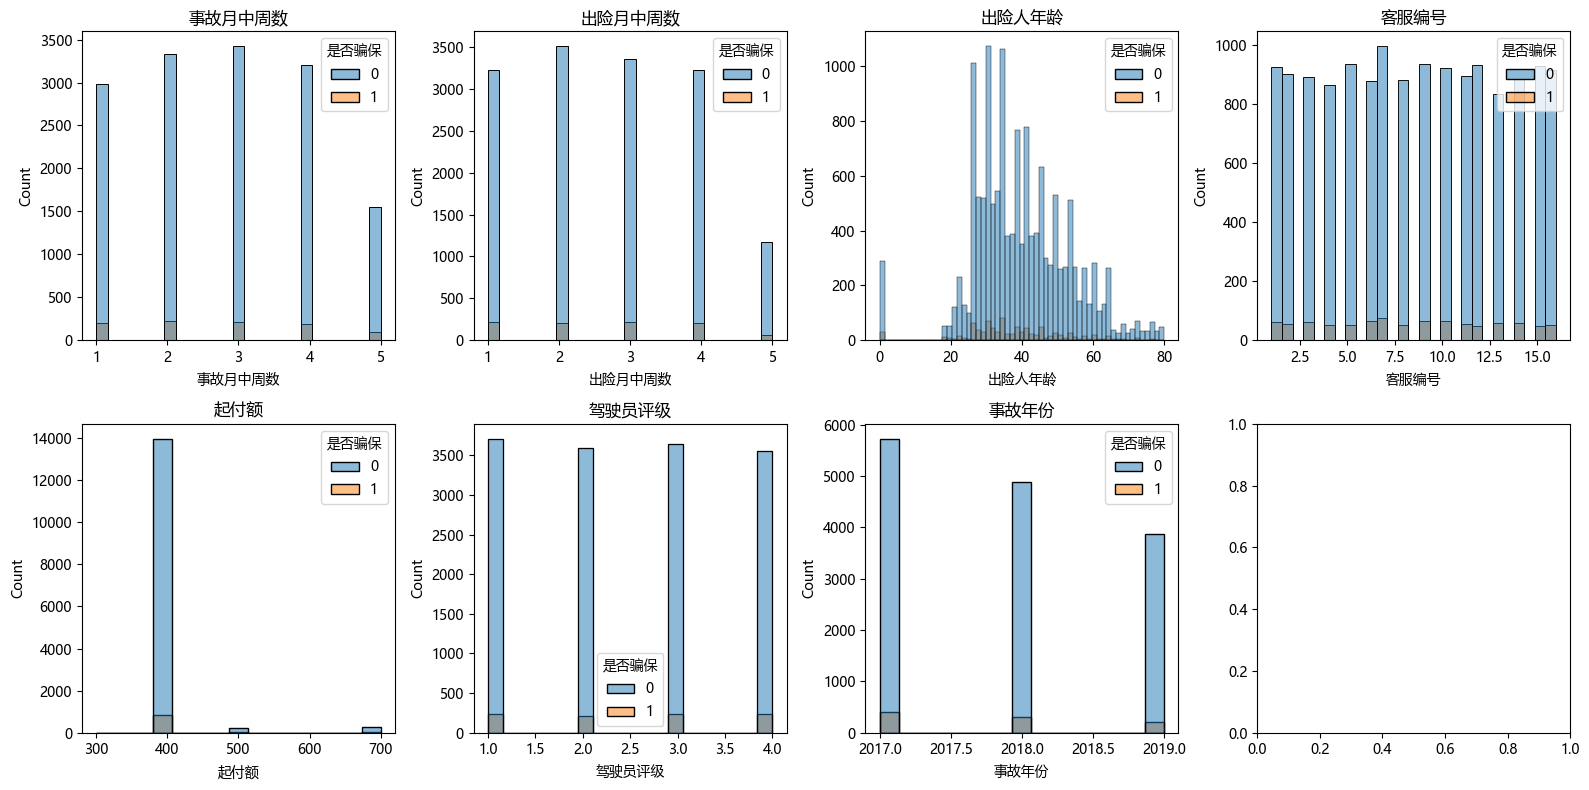

In [43]:
# visualize the distribution of continous variables 连续型变量分布可视化
# 每行显示的图形数量
ncol = 4
# 行数
nrow = int(np.ceil(len(continous_feature) / ncol)) 
# 设置图形大小
fig, axes = plt.subplots(nrow, ncol, figsize=(ncol * 4, nrow * 4)) 

for i, var in enumerate(continous_feature):
    # 位置
    loc = (i // ncol, i % ncol)
    # 绘制直方图
    sns.histplot(data = df, x = var, hue = target, ax = axes[loc]) 
    # 设置标题
    axes[loc].set_title(var) 
    
# 调整图形间距    
fig.tight_layout() 

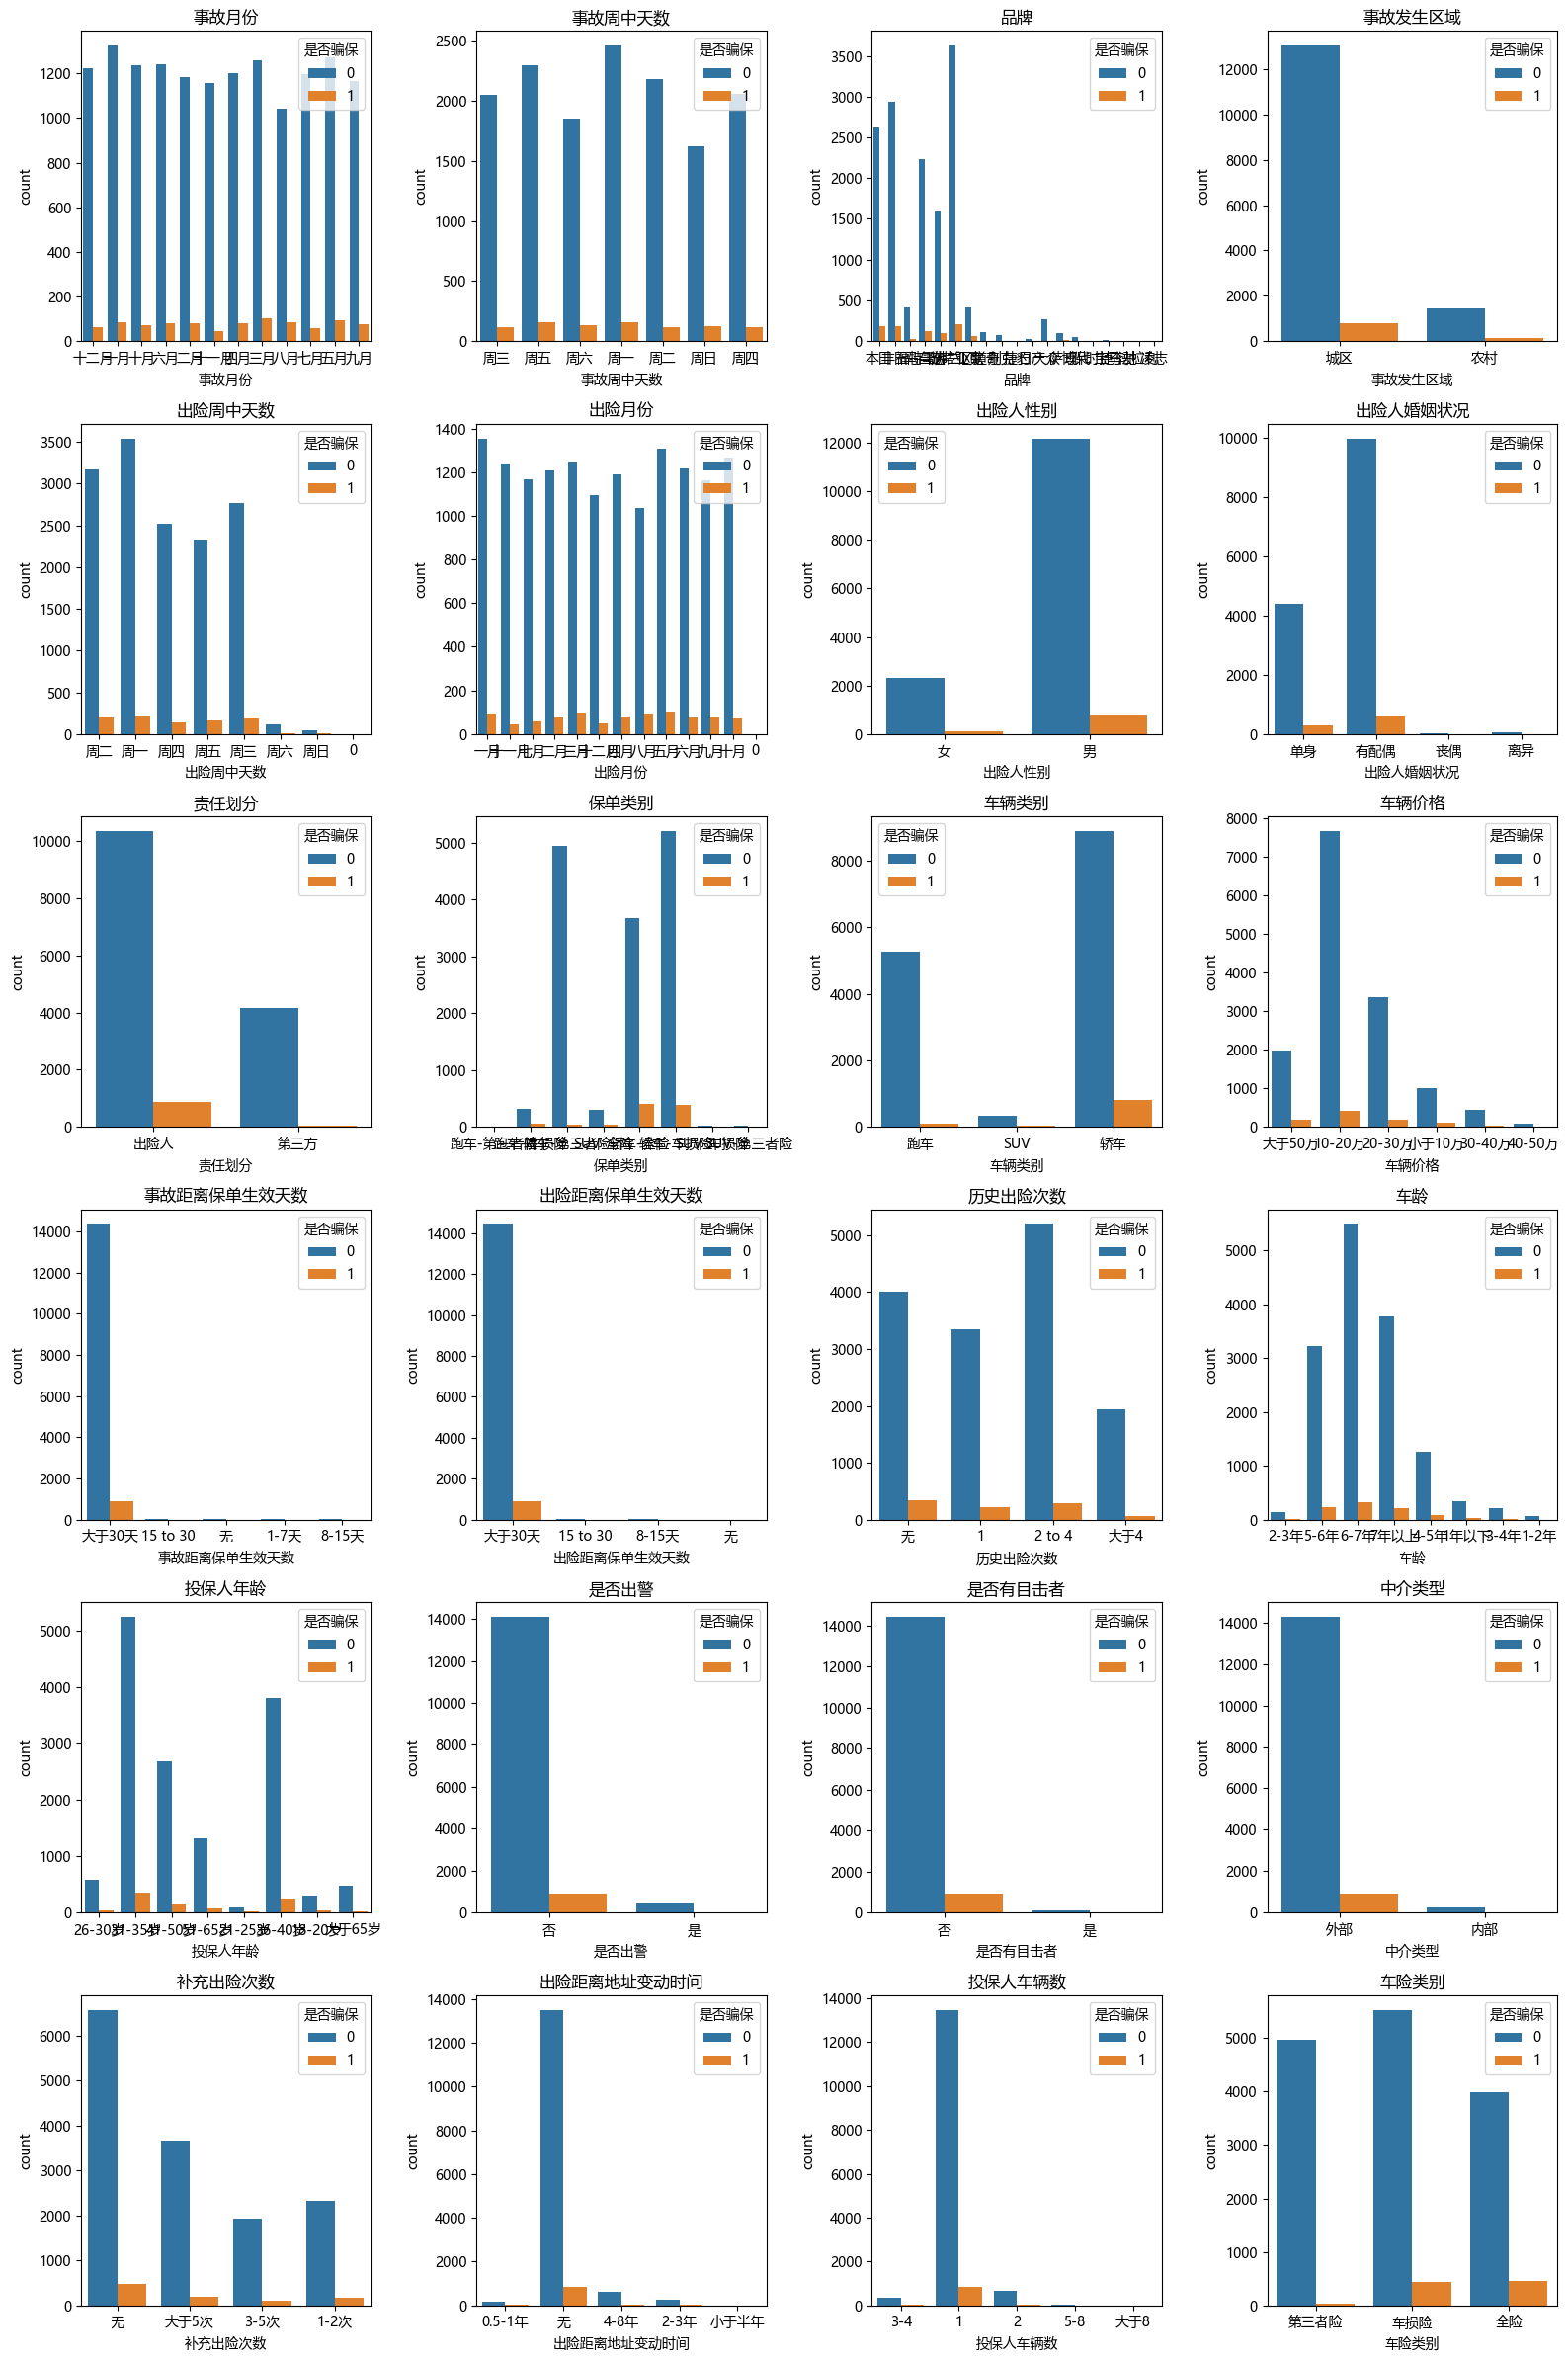

In [44]:
# visualize the distribution of categorical variables 离散型变量分布可视化
# 每行显示的图形数量
ncol = 4
# 行数
nrow = int(np.ceil(len(categorical_feature) / ncol))
# 设置图形大小
fig, axes = plt.subplots(nrow, ncol, figsize=(ncol * 4, nrow * 4))

for i, var in enumerate(categorical_feature):
    # 位置
    loc = (i // ncol, i % ncol)
    # 绘制直方图
    sns.countplot(data = df, x = var, hue = target, ax = axes[loc])
    # 设置标题
    axes[loc].set_title(var)

# 调整图形间距
fig.tight_layout()

In [45]:
# 提取训练特征
feature = continous_feature + categorical_feature

# 将类别特征转换为一位有效编码
# 手动选择特征以获取更好结果
df1 = pd.get_dummies(df[feature],
                     columns = ['事故月份',
                                '事故月中周数',
                                '事故周中天数',
                                '品牌',
                                '事故发生区域',
                                '出险周中天数',
                                '出险月份',
                                '出险月中周数',
                                '出险人性别',
                                '出险人婚姻状况',
                                '责任划分',
                                '保单类别',
                                '车辆类别',
                                '车辆价格',
                                '起付额',
                                '驾驶员评级',
                                '事故距离保单生效天数',
                                '出险距离保单生效天数',
                                '历史出险次数',
                                '车龄',
                                '投保人年龄',
                                '是否出警',
                                '是否有目击者',
                                '中介类型',
                                '补充出险次数',
                                '出险距离地址变动时间',
                                '投保人车辆数',
                                '事故年份',
                                '车险类别'])

In [46]:
# 拆分训练集 测试集
X_train, X_test, y_train, y_test = train_test_split(df1, df[target], test_size = 0.2, random_state = 42)

BaggingClassifier为引导聚集分类器，其算法为重复n轮，每轮先将训练集中的数据进行放回抽样，然后用抽样结果进行训练，n轮结束后将每轮结果平均求和从而得出最终的模型

In [47]:
# 初始化模型
# 高斯朴素贝叶斯分类器
clf1 = BaggingClassifier(GaussianNB(), random_state = 42)
# 逻辑斯谛回归 使用L2正则化
clf2 = BaggingClassifier(LogisticRegression(penalty='l2'), random_state = 42)
# 随机森林分类器
clf3 = RandomForestClassifier(criterion = 'entropy', random_state = 42)
# AdaBoost分类器
clf4 = AdaBoostClassifier(random_state = 42)
# XGBoost分类器
# tree_method使用GPU加速训练过程，方便快速寻找最佳参数，需去除
clf5 = XGBClassifier(random_state = 42, tree_method = 'gpu_hist')

网格搜索寻找最佳参数，可以不加入

In [48]:
# 通过网格搜索，寻找最优参数
adb_params = { 
    # 估计器个数
    "n_estimators": [100, 200, 300, 500],
    # 学习率
    "learning_rate": [0.05, 0.1, 0.3, 0.5],
}

In [49]:
# 初始化网格搜索
adb_classifier = GridSearchCV( 
    # 模型
    estimator = clf4, 
    # 网格参数
    param_grid = adb_params, 
    # 以精度作为评价指标 
    scoring = 'precision', 
    # 交叉验证折数
    cv = 5 
)

In [50]:
# 训练并找出最佳模型
adb_classifier.fit(X_train, y_train)
print(adb_classifier.best_params_)

{'learning_rate': 0.05, 'n_estimators': 200}


In [51]:
# 通过网格搜索，寻找最优参数
xgb_params = { 
    # 估计器个数
    "n_estimators": [100, 200, 300, 500],
    # 学习率
    "learning_rate": [0.05, 0.1, 0.3, 0.5],
    # 最大树深度
    "max_depth": [3, 5, 7, 10]
}

In [52]:
# 初始化网格搜索
xgb_classifier = GridSearchCV(
    # 模型
    estimator = clf5,
    # 网格参数
    param_grid = xgb_params,
    # 以精度作为评价指标 
    scoring = 'precision',
    # 交叉验证折数
    cv = 5
)

In [53]:
# 训练并找出最佳模型
xgb_classifier.fit(X_train, y_train)
print(xgb_classifier.best_params_)

{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300}


In [54]:
# 将分类器按网格搜索结果初始化
clf4 = AdaBoostClassifier(learning_rate = 0.05, n_estimators= 200, random_state = 42)
clf5 = XGBClassifier(learning_rate = 0.05, max_depth= 3, n_estimators= 300, random_state = 42)

朴素贝叶斯准确度: 0.192
朴素贝叶斯精度: 0.071
朴素贝叶斯召回率: 0.970
朴素贝叶斯F1分数: 0.133
朴素贝叶斯曲线下面积分数: 0.790

逻辑斯谛准确度: 0.936
逻辑斯谛精度: 0.400
逻辑斯谛召回率: 0.010
逻辑斯谛F1分数: 0.020
逻辑斯谛曲线下面积分数: 0.826

随机森林准确度: 0.938
随机森林精度: 1.000
随机森林召回率: 0.025
随机森林F1分数: 0.050
随机森林曲线下面积分数: 0.834

AdaBoost准确度: 0.935
AdaBoost精度: 0.222
AdaBoost召回率: 0.010
AdaBoostF1分数: 0.019
AdaBoost曲线下面积分数: 0.813

XGBoost准确度: 0.939
XGBoost精度: 1.000
XGBoost召回率: 0.046
XGBoostF1分数: 0.087
XGBoost曲线下面积分数: 0.858



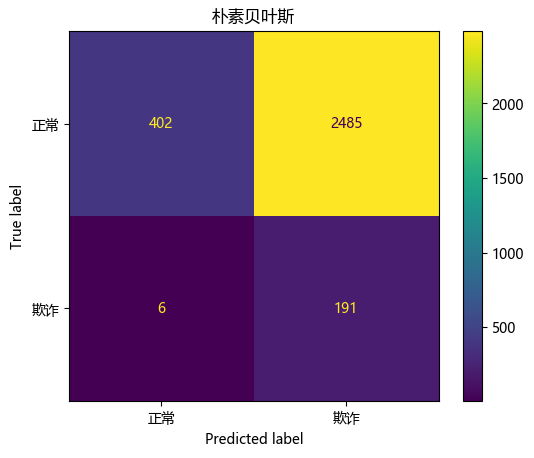

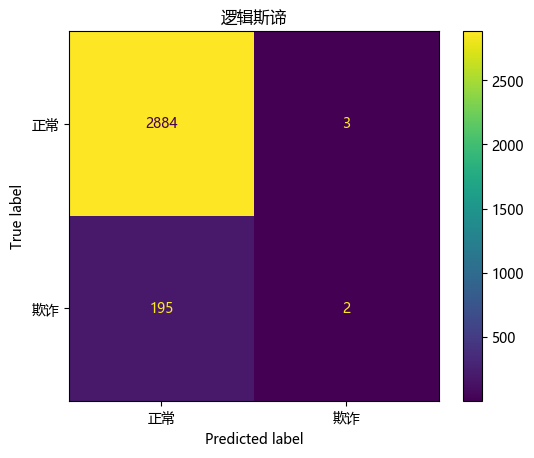

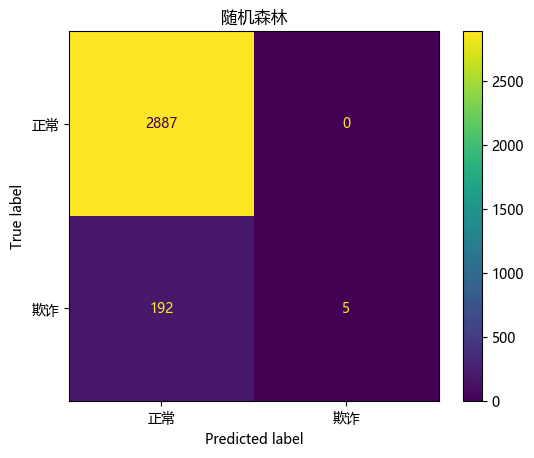

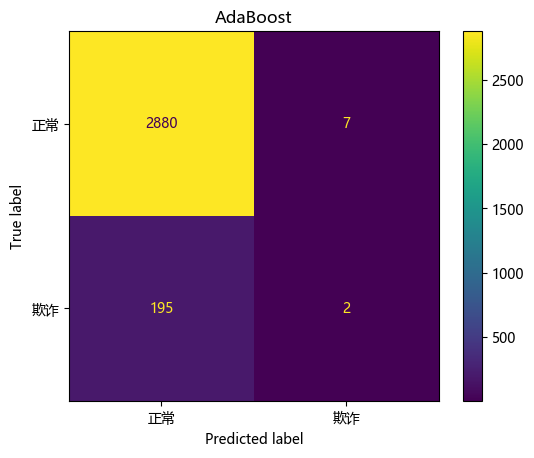

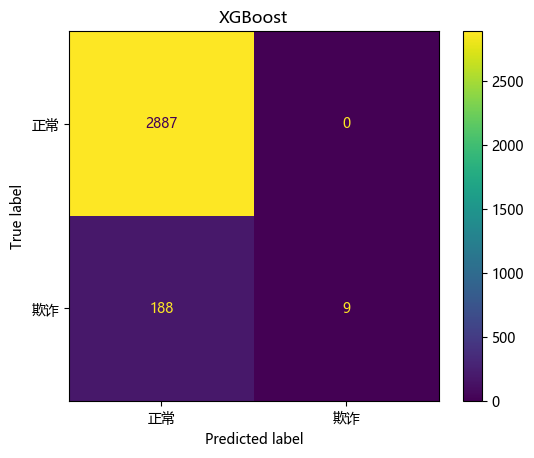

In [55]:
# 循环训练每个分类器并输出每个分类器的分数和混淆矩阵
for clf, label in zip([clf1, clf2, clf3, clf4, clf5],
                      ['朴素贝叶斯',
                       '逻辑斯谛',
                       '随机森林',
                       'AdaBoost',
                       'XGBoost']):
    
    # 训练模型
    clf = clf.fit(X = X_train, y = y_train)
    # 预测分类概率
    y_score = clf.predict_proba(X_test)[:, 1]
    # 预测结果
    y_pred = clf.predict(X_test)

    # 准确度
    print('%s准确度: %.3f' %(label, accuracy_score(y_test, y_pred)))
    # 精度
    print('%s精度: %.3f' %(label, precision_score(y_test, y_pred)))
    # 召回率
    print('%s召回率: %.3f' %(label, recall_score(y_test, y_pred)))
    # F1分数
    print('%sF1分数: %.3f' %(label, f1_score(y_test, y_pred)))
    # 曲线下面积分数
    print('%s曲线下面积分数: %.3f\n' %(label, roc_auc_score(y_test, y_score)))

    # 绘制混淆矩阵
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['正常', '欺诈'])
    disp.plot()
    disp.ax_.set_title(label)

In [56]:
# 使用投票分类器优化结果
# 定义函数优化调参过程
# clf为参与投票的子分类器
# weight为参与投票分类器的投票权重
def train_data_from_voting(clf, weight):
    # 初始化投票分类器
    eclf = EnsembleVoteClassifier(
        # 参与投票的子分类器
        clfs = clf,
        # 投票类别，软投票会将每个子分类器预测的概率进行加权平均
        voting = 'soft',
        # 子分类器投票权重
        weights = weight,
        # 是否再次训练，False时投票分类器会认为子分类器已经训练完毕
        fit_base_estimators = False)
    
    # 即使不再次训练也需要调用fit激活分类器
    eclf = eclf.fit(X = X_train,y = y_train)
    # 预测分类概率
    y_score = eclf.predict_proba(X_test)[:,1]
    # 预测结果
    y_pred = eclf.predict(X_test)

    # 准确度
    print ("投票分类器准确度: %.3f" %(accuracy_score(y_test, y_pred)))
    # 精度
    print("投票分类器精度: %.3f" %(precision_score(y_test, y_pred)))
    # 召回率
    print("投票分类器召回率: %.3f" %(recall_score(y_test, y_pred)))
    # f1分数
    print("投票分类器F1分数: %.3f" %(f1_score(y_test, y_pred)))
    # 曲线下面积
    print("投票分类器曲线下面积: %.3f" %(roc_auc_score(y_test, y_score)))

    # 绘制混淆矩阵
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['正常', '欺诈'])
    disp.plot()
    disp.ax_.set_title('投票分类器')

    # 返回训练完毕的分类器
    return eclf

投票分类器准确度: 0.940
投票分类器精度: 0.875
投票分类器召回率: 0.071
投票分类器F1分数: 0.131
投票分类器曲线下面积: 0.837


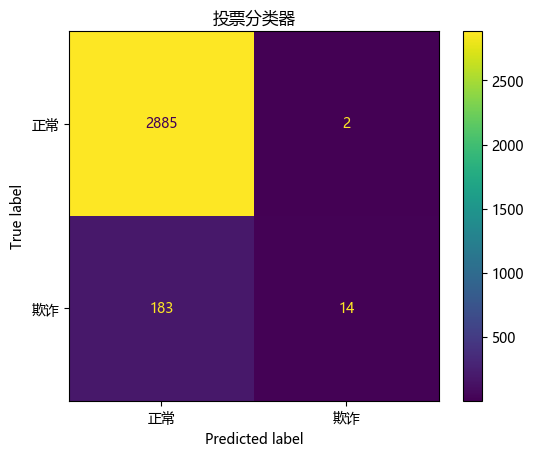

In [57]:
# 使用贝叶斯、随机森林、AdaBoost、XGBoost分类器投票，权重均为1
train_data_from_voting([clf1, clf2, clf3, clf4, clf5], [1, 1, 1, 1, 1]);

投票分类器准确度: 0.547
投票分类器精度: 0.116
投票分类器召回率: 0.919
投票分类器F1分数: 0.206
投票分类器曲线下面积: 0.825


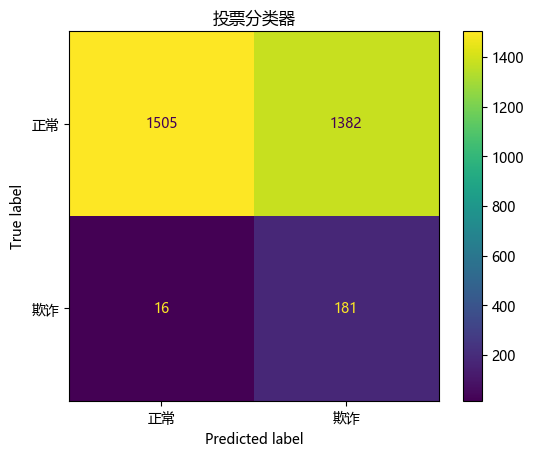

In [58]:
# 使用贝叶斯和XGBoost分类器投票，权重均为1
train_data_from_voting([clf1, clf5], [1, 1]);

投票分类器准确度: 0.787
投票分类器精度: 0.188
投票分类器召回率: 0.701
投票分类器F1分数: 0.296
投票分类器曲线下面积: 0.827


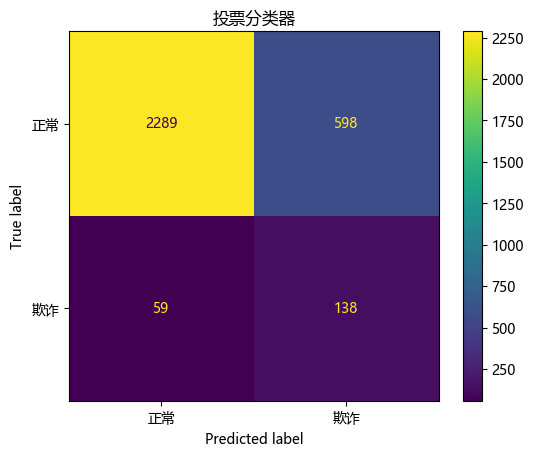

In [61]:
# 一种最优的投票分类器结果
elcf = train_data_from_voting([clf1, clf3, clf5], [4, 1, 4])